# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [18]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS, RTHETA_COLS, XY_RTHETA_COLS, XY_VXVY_RTHETA_COLS
from isaac.evaluation import evaluate_saved_model
from isaac.statistical_tests import z_test
from isaac.visualization import plot_confusion_matrix

from scipy.stats import ttest_ind, ttest_rel, f_oneway

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm

In [19]:
device = get_cuda_device_if_available()
print(device)

cuda:0


In [20]:
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

In [21]:
dataset_path = "data/r_test_trials.h5"
TRIALS = read_dataset(dataset_path, n_trials=1000, shuffle=True, seed=0)

In [22]:
normalise_data = True

features = "xy_vxvy_rtheta"
d = {"rtheta": RTHETA_COLS, "xy_vxvy": BASIC_TRAINING_COLS,
     "xy_rtheta": XY_RTHETA_COLS, "xy_vxvy_rtheta": XY_VXVY_RTHETA_COLS}

network_dims = (len(d[features]), HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
multiclass = False
seq_end = 2700
step_size = 3
N_MODELS = None

def get_question_accuracy_for_group_of_models(question_type):
    global N_MODELS
    model_paths = sorted(glob.glob("models/GRU_singlebranch/"+features+"/best_"+question_type+"_model_seed_*.pt"))
    scaler_path = "scalers/GRU_singlebranch/"+question_type+"_"+features+"_scaler.sk"
    class_columns = FORCE_CLASS_COLS if question_type == "force" else MASS_CLASS_COLS

    N_MODELS = len(model_paths)
    
    model_arch = MultiBranchModel if multiclass else ComplexRNNModel
    
    accuracies, predicted = evaluate_saved_model(tqdm(model_paths), network_dims, None, 
                                                 training_columns=d[features], class_columns=class_columns, 
                                                 step_size=step_size, seq_end=seq_end, scaler_path=scaler_path,
                                                 arch=model_arch, multiclass=multiclass, trials=TRIALS)
    
    if multiclass:
        if question_type == "mass":
            question_index = 0
        else:
            question_index = 1

        accuracies = np.stack(accuracies)[:, question_index]

        predicted = [x[:, question_index].numpy() for x in predicted]

    return accuracies, predicted

# T-test for MASS questions

## Load model's predictions

In [23]:
print("MASS")
question_type = "mass"
group_mass_acc, group_mass_prediction = get_question_accuracy_for_group_of_models(question_type)
     
print("\nFORCE")
question_type = "force"
group_force_acc, group_force_prediction = get_question_accuracy_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]


FORCE


100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


In [24]:
np.mean(group_mass_acc), np.std(group_mass_acc)

(68.49600000000001, 1.9779747217798307)

In [25]:
np.argmax(group_mass_acc)

4

In [26]:
np.mean(group_force_acc), np.std(group_force_acc)

(72.524, 1.1724436020551274)

In [27]:
sorted(zip(group_force_acc, range(len(group_force_acc))), key=lambda x: x[0], reverse=True)[:5]

[(75.2, 18), (74.5, 17), (74.2, 16), (74.2, 22), (73.2, 10)]

In [28]:
sorted(zip(group_mass_acc, range(len(group_mass_acc))), key=lambda x: x[0], reverse=True)[:5]

[(72.5, 4), (72.4, 20), (71.2, 18), (71.1, 11), (70.7, 13)]

#### Is the model significantly better answering force questions than mass questions?

In [29]:
print(ttest_ind(group_mass_acc, group_force_acc))

Ttest_indResult(statistic=-8.582031395263144, pvalue=2.947964259450167e-11)


In [30]:
from sklearn.metrics import confusion_matrix
from isaac.visualization import plot_confusion_matrix

In [31]:
mass_classes = []
force_classes = []

for t in TRIALS:
    mass_classes.append(np.argmax(t[list(MASS_CLASS_COLS)].iloc[0].values))
    force_classes.append(np.argmax(t[list(FORCE_CLASS_COLS)].iloc[0].values))

In [32]:
mass_classes = mass_classes * N_MODELS
force_classes = force_classes * N_MODELS

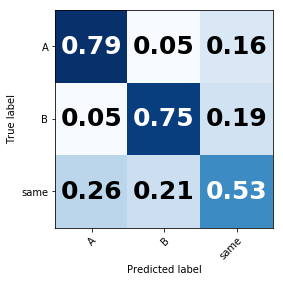

In [33]:
plot_confusion_matrix(mass_classes, np.concatenate(group_mass_prediction), MASS_CLASS_COLS, normalize=True)

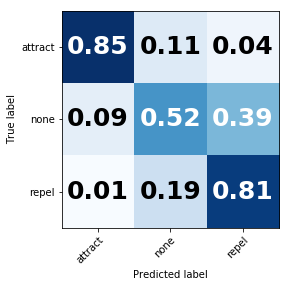

In [34]:
plot_confusion_matrix(force_classes, np.concatenate(group_force_prediction), FORCE_CLASS_COLS, normalize=True)